In [1]:
distances = [15, 35]
doubleplanes = [12, 30]
energies = [200, 600, 1000]
neutrons = [1]
physicss = ["bert", "bic", "inclxx"]

In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import ROOT

ROOT.ROOT.EnableThreadSafety()

Welcome to JupyROOT 6.16/00


In [3]:
def process_ttree(ttree, neutron):
    primary_neutron_track_ids = list(range(0, neutron))
    data = []
    for evt in ttree:
        z = -1.0
        x = -999
        for nTrack, track in enumerate(evt.MCTrack):
            if track.GetMotherId() in primary_neutron_track_ids:
                z = track.GetStartZ()
                x = track.GetStartX()
                break

        nTracks = evt.MCTrack.GetEntries()
        edep = sum([h.GetE() for h in evt.NeulandHits])
        data.append((nTracks, z, edep, x))
    return pd.DataFrame(data, columns=["nTracks", "Z", "E", "X"])

In [4]:
def process(distance, doubleplane, energy, neutron, physics, prnt=False):
    simufile = f"output/{distance}m_{doubleplane}dp_{energy}AMeV_{neutron}n_{physics}.simu.root"
    digifile = f"output/{distance}m_{doubleplane}dp_{energy}AMeV_{neutron}n_{physics}.digi.root"

    tfile = ROOT.TFile.Open(simufile)
    ttree = tfile.evt
    ttree.AddFriend("evt", digifile)

    nEvents = ttree.GetEntries()
    data = process_ttree(ttree, neutron)

    tfile.Close()
    del tfile

    if prnt:
        hist = np.histogram(data["Z"], bins=400, range=(-1, 4000))
        fig = plt.figure(figsize=(6.224, 6.224 / 1.618))
        ax = fig.add_subplot(111)
        ax.plot(hist[1][:-1], hist[0])
        ax.set_yscale("log")
        #display(fig)
        
        histx = np.histogram(data["X"], bins=400, range=(-200, +200))
        fig2 = plt.figure(figsize=(6.224, 6.224 / 1.618))
        ax2 = fig2.add_subplot(111)
        ax2.plot(histx[1][:-1], histx[0])
        ax2.set_yscale("log")
        #display(fig2)

    noreac = data[(data["Z"] < 0)]
    airreac_yedep = data[(data["Z"] < distance * 100) & (data["Z"] > 0) & (data["E"] > 0)]
    airreac_nedep = data[(data["Z"] < distance * 100) & (data["Z"] > 0) & (data["E"] < 0.001)]
    detreac_yedep = data[(data["Z"] > distance * 100) & (data["E"] > 0)]
    detreac_nedep = data[(data["Z"] > distance * 100) & (data["E"] < 0.001)]
    allreac = data[(data["E"] > 0)]

    if prnt:
        print(f"{distance}m | {doubleplane}dp | {energy}AMeV | {neutron}n | QGSP_{physics.upper()}_HP")
        print(f"Simulated Events: {nEvents}")
        print(f"  - No Reaction: {round(noreac.shape[0] / nEvents * 100, 2)}%")
        print(f"  - Reactions between target and detector")
        print(f"    - w/o hits: {round(airreac_nedep.shape[0] / nEvents * 100, 2)}%")
        print(f"    - w/  hits: {round(airreac_yedep.shape[0] / nEvents * 100, 2)}%")
        print(f"  - Reactions in the detector:")
        print(f"    - w/o hits: {round(detreac_nedep.shape[0] / nEvents * 100, 2)}%")
        print(f"    - w/  hits: {round(detreac_yedep.shape[0] / nEvents * 100, 2)}%")
        print(f"  - All detected: {round(allreac.shape[0] / nEvents * 100, 2)}%")
        print("")

    if not prnt:
        return (
            distance,
            doubleplane,
            energy,
            neutron,
            physics,
            nEvents,
            round(noreac.shape[0] / nEvents * 100, 2),
            round(airreac_nedep.shape[0] / nEvents * 100, 2),
            round(airreac_yedep.shape[0] / nEvents * 100, 2),
            round(detreac_nedep.shape[0] / nEvents * 100, 2),
            round(detreac_yedep.shape[0] / nEvents * 100, 2),
            round(allreac.shape[0] / nEvents * 100, 2),
        )

15m | 30dp | 600AMeV | 1n | QGSP_INCLXX_HP
Simulated Events: 100000
  - No Reaction: 1.17%
  - Reactions between target and detector
    - w/o hits: 2.8%
    - w/  hits: 0.81%
  - Reactions in the detector:
    - w/o hits: 1.14%
    - w/  hits: 94.08%
  - All detected: 94.89%

35m | 30dp | 600AMeV | 1n | QGSP_INCLXX_HP
Simulated Events: 100000
  - No Reaction: 1.79%
  - Reactions between target and detector
    - w/o hits: 5.97%
    - w/  hits: 0.6%
  - Reactions in the detector:
    - w/o hits: 1.15%
    - w/  hits: 90.5%
  - All detected: 91.1%



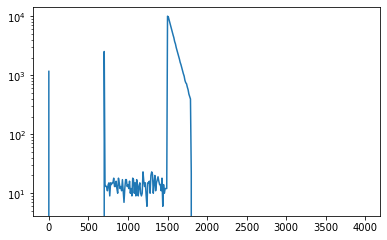

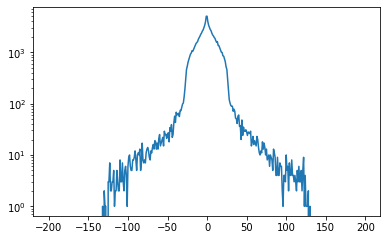

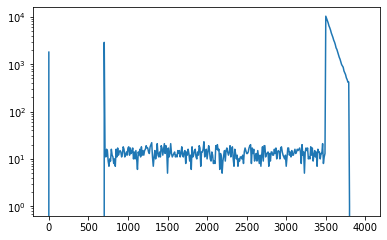

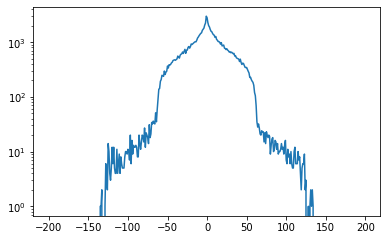

In [5]:
process(15, 30, 600, 1, "inclxx", prnt=True)
process(35, 30, 600, 1, "inclxx", prnt=True)

In [6]:
results = pd.DataFrame(
    joblib.Parallel(n_jobs=-1, backend="multiprocessing", verbose=1)(
        joblib.delayed(process)(
            distance=distance, doubleplane=doubleplane, energy=energy, neutron=neutron, physics=physics,
        )
        for distance in distances
        for energy in energies
        for doubleplane in doubleplanes
        for neutron in neutrons
        for physics in physicss
    )
)

results.columns = [
    "Dist",
    "DP",
    "Energy",
    "N",
    "Physics",
    "nEvents",
    "NoReac",
    "Air-N",
    "Air-Y",
    "Det-N",
    "Det-Y",
    "All-Y",
]

results.to_csv("results/ReactionPositions.csv")

display(results)

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  36 | elapsed:  2.0min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  4.4min finished


,Dist,DP,Energy,N,Physics,nEvents,NoReac,Air-N,Air-Y,Det-N,Det-Y,All-Y
0,15,12,200,1,bert,100000,18.58,3.22,0.45,8.41,69.34,69.79
1,15,12,200,1,bic,100000,18.45,3.02,0.51,5.96,72.06,72.57
2,15,12,200,1,inclxx,100000,18.41,3.16,0.38,6.65,71.40,71.78
3,15,30,200,1,bert,100000,1.76,3.10,0.47,2.19,92.48,92.95
4,15,30,200,1,bic,100000,1.71,3.01,0.56,1.56,93.16,93.72
5,15,30,200,1,inclxx,100000,1.68,3.20,0.40,1.69,93.04,93.44
6,15,12,600,1,bert,100000,15.85,2.84,0.83,6.37,74.12,74.94
7,15,12,600,1,bic,100000,15.72,2.76,0.83,5.44,75.26,76.08
8,15,12,600,1,inclxx,100000,15.93,2.87,0.80,5.99,74.41,75.21
9,15,30,600,1,bert,100000,1.15,2.77,0.88,1.26,93.95,94.83
